# Data pre-processing

In [ ]:
import cv2
import os
import numpy as np 
from keras.utils import np_utils
from zipfile import ZipFile


extract images to working directory

In [ ]:
file_name = "./fmr_dataset1.zip"
with ZipFile(file_name, 'r') as zipf:
  zipf.extractall() 


parse folder names (with/without mask) to categories and map to binary labels

In [ ]:
data_path='./fmr_dataset1'
classes=os.listdir(data_path)
labels=[l for l, c in enumerate(classes)]
classes_labels = dict(zip(classes, labels))
print(classes_labels)

{'with_mask': 0, 'without_mask': 1}


load the images to greyscale and resize them

In [ ]:
IM_SIZE = 50
data = []
labels = []

for c in classes:
    class_folder_path=os.path.join(data_path, c)
    im_names=os.listdir(class_folder_path)
        
    for n in im_names:
        im_path = os.path.join(class_folder_path,n)
        im_gray = cv2.imread(im_path, 0)         
        im_resized = cv2.resize(im_gray,(IM_SIZE,IM_SIZE))
        data.append(im_resized)
        labels.append(classes_labels[c])

normalize the pixel arrays and convert labels to one-hot vectors, save those variables for use with keras

In [ ]:
data = np.array(data)/255.
data = data.reshape((data.shape[0],IM_SIZE,IM_SIZE,1))
labels = np_utils.to_categorical(np.array(labels))

# Training 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split

create a cnn 

In [ ]:
model=Sequential()
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 200)       2000      
_________________________________________________________________
activation (Activation)      (None, 48, 48, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12100)             0

compile it

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)

train the cnn

In [ ]:
training = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
31/31 [==============================] - 17s 545ms/step - loss: 0.6321 - accuracy: 0.6313 - val_loss: 0.5869 - val_accuracy: 0.6815
Epoch 2/10
31/31 [==============================] - 17s 546ms/step - loss: 0.4248 - accuracy: 0.8293 - val_loss: 0.2756 - val_accuracy: 0.9194
Epoch 3/10
31/31 [==============================] - 17s 546ms/step - loss: 0.2426 - accuracy: 0.9061 - val_loss: 0.2422 - val_accuracy: 0.8952
Epoch 4/10
31/31 [==============================] - 17s 544ms/step - loss: 0.1909 - accuracy: 0.9303 - val_loss: 0.1648 - val_accuracy: 0.9395
Epoch 5/10
31/31 [==============================] - 17s 547ms/step - loss: 0.1379 - accuracy: 0.9515 - val_loss: 0.2053 - val_accuracy: 0.9153
Epoch 6/10
31/31 [==============================] - 17s 547ms/step - loss: 0.1480 - accuracy: 0.9525 - val_loss: 0.1054 - val_accuracy: 0.9718
Epoch 7/10
31/31 [==============================] - 17s 546ms/step - loss: 0.1148 - accuracy: 0.9556 - val_loss: 0.1207 - val_accuracy: 0.9556

# Evaluation

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


plot loss and accuracy on train and dev sets

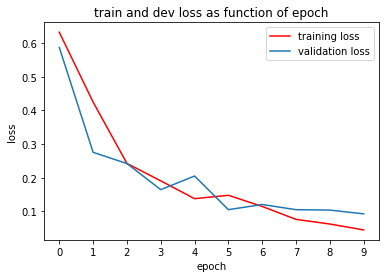

In [ ]:
plt.plot(training.history['loss'],'r', label='training loss')
plt.plot(training.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(np.arange(10))
plt.title('train and dev loss as function of epoch')
plt.legend()
plt.show()

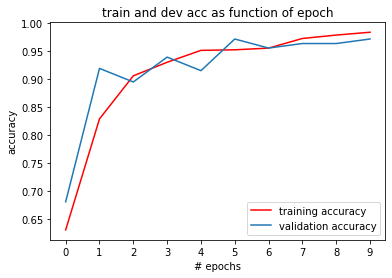

In [ ]:
plt.plot(training.history['accuracy'],'r',label='training accuracy')
plt.plot(training.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.xticks(np.arange(10))
plt.ylabel('accuracy')
plt.title('train and dev acc as function of epoch')
plt.legend()
plt.show()

evaluate the model

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 101ms/step - loss: 0.1056 - accuracy: 0.9710


[0.10560494661331177, 0.9710144996643066]

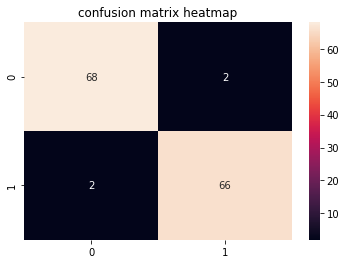

In [ ]:
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot=True)
plt.title('confusion matrix heatmap')
plt.show()

In [ ]:
cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cr)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        70
           1       0.97      0.97      0.97        68

    accuracy                           0.97       138
   macro avg       0.97      0.97      0.97       138
weighted avg       0.97      0.97      0.97       138



In [ ]:
y_test[0]

array([0., 1.], dtype=float32)

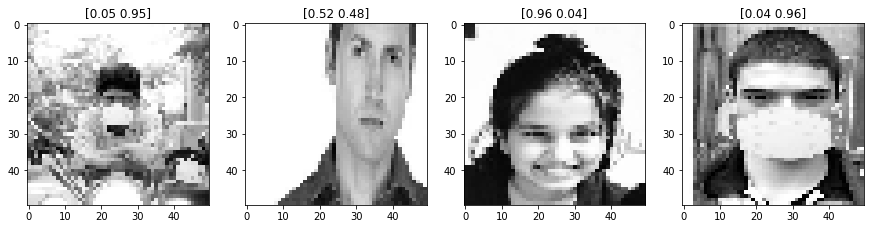

In [ ]:
misses = np.unique(np.where(y_test != np.round(y_pred))[0])
fig, ax = plt.subplots(1,4, figsize=(15,15))
for i, img in enumerate(misses):
  ax[i].imshow(X_test[img].flatten().reshape(50,50),cmap='gray')
  ax[i].set_title(str(np.round(y_pred[img],2)))
plt.show()